# Initialization

In [1]:
import sys
sys.path.append("..")

In [5]:
## Imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(style="white", palette="muted")
import mydatasets
import utils
import math
from sklearn.neighbors import NearestNeighbors
import os

In [2]:
DATASET="mediamill"
SPLIT=0

In [3]:
print("Dataset :",DATASET,"/ Split :",SPLIT)

Dataset : mediamill / Split : 0


In [19]:
curr_dir=os.getcwd()
os.chdir("..")
if DATASET in ["mediamill","delicious"]:
    full_dataset,trn_splits,tst_splits=mydatasets.load_small_dataset(DATASET)
    trn_data,tst_data=mydatasets.get_small_dataset_split(full_dataset,trn_splits,tst_splits,SPLIT)
else:
    trn_data,tst_data=mydatasets.load_large_dataset(DATASET)
os.chdir(curr_dir)
x_mat,y_mat=mydatasets.get_arrays(trn_data)
x_tst,y_tst=mydatasets.get_arrays(tst_data)

Loading datasets
../data/Mediamill/Mediamill_data.txt
../data/Mediamill/mediamill_trSplit.txt
../data/Mediamill/mediamill_tstSplit.txt
Number of splits : 10
## HEADER ##
#Point : 43907 , #Features : 120 , #Labels : 101


In [20]:
print("x_mat :",x_mat.shape)
print("y_mat :",y_mat.shape)
print("x_tst :",x_tst.shape)
print("y_tst :",y_tst.shape)

x_mat : (30993, 120)
y_mat : (30993, 101)
x_tst : (12914, 120)
y_tst : (12914, 101)


# Analysis

In [21]:
num_points=x_mat.shape[0]
num_features=x_mat.shape[1]
num_labels=y_mat.shape[1]
print("----Training set stats----")
print("Number of points :",num_points)
print("Feature dimensionality :",num_features)
print("Label dimensionality :",num_labels)

----Training set stats----
Number of points : 30993
Feature dimensionality : 120
Label dimensionality : 101


Let's reorder by count for simplicity

In [26]:
label_counts=np.sum(y_mat,axis=0)
reorder_idcs=np.argsort(label_counts)
y_mat=y_mat[:,reorder_idcs]

## Empty labelsets

In [25]:
cardinalities=np.sum(y_mat,axis=1)
num_empty=np.sum((cardinalities==0)*1)
percent=np.round(100*num_empty/num_points,decimals=3)
print("Number of points with empty labelsets :",num_empty,",",percent,"%")

Number of points with empty labelsets : 1197 , 3.862 %


## Label counts

### Mean Stats

In [29]:
label_counts=np.sum(y_mat,axis=0)
count_df=pd.DataFrame(label_counts,columns=["count"])
count_df["percent"]=np.round(100*count_df["count"]/num_points,decimals=3)
count_df["log_count"]=np.log(np.maximum(count_df["count"],1))
display(count_df)
display(count_df.describe())

,count,percent,log_count
0,22,0.071,3.091042
1,23,0.074,3.135494
2,24,0.077,3.178054
3,24,0.077,3.178054
4,24,0.077,3.178054
...,...,...,...
96,6270,20.230,8.743532
97,10641,34.334,9.272470
98,11140,35.944,9.318298
99,19696,63.550,9.888171


,count,percent,log_count
count,101.000000,101.000000,101.000000
mean,1345.752475,4.342109,5.557307
std,3486.967150,11.250828,1.754434
min,22.000000,0.071000,3.091042
25%,68.000000,0.219000,4.219508
50%,218.000000,0.703000,5.384495
75%,886.000000,2.859000,6.786717
max,23910.000000,77.146000,10.082052


### Empty labels

In [30]:
num_empty=np.sum((label_counts==0)*1)
print("There are",num_empty,"labels with no examples in this dataset")

There are 0 labels with no examples in this dataset


### Distribution/Frequency

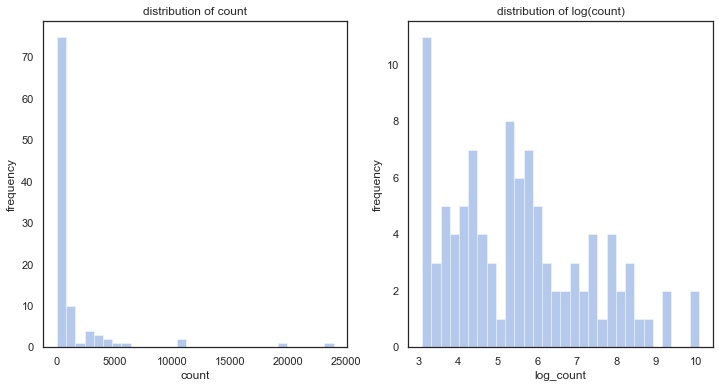

In [51]:
fig,axes=plt.subplots(1,2,squeeze=False,figsize=(12,6))
axes[0][0].set_title("distribution of count")
axes[0][0].set_xlabel("count")
axes[0][0].set_ylabel("frequency")
sb.distplot(count_df["count"],kde=False,bins=30,ax=axes[0][0])
axes[0][1].set_title("distribution of log(count)")
axes[0][1].set_xlabel("log(count)")
axes[0][1].set_ylabel("frequency")
_=sb.distplot(count_df["log_count"],kde=False,bins=30,ax=axes[0][1])

### Counts vs Rank

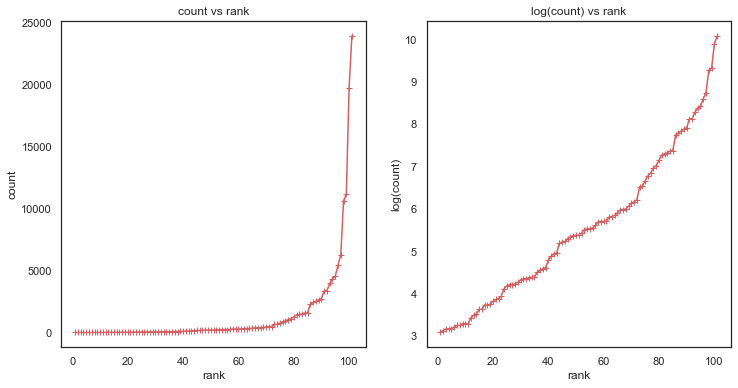

In [44]:
fig,axes=plt.subplots(1,2,squeeze=False,figsize=(12,6))
axes[0][0].set_title("count vs rank")
axes[0][0].set_xlabel("rank")
axes[0][0].set_ylabel("count")
axes[0][0].plot(np.arange(1,num_labels+1),count_df["count"].to_numpy(),"r+-")
axes[0][1].set_title("log(count) vs rank")
axes[0][1].set_xlabel("rank")
axes[0][1].set_ylabel("log(count)")
_=axes[0][1].plot(np.arange(1,num_labels+1),count_df["log_count"].to_numpy(),"r+-")

## Label Overlap

### Label Cooccurrences/Intersections

In [52]:
cc_mat=utils.generate_cooccurrence_matrix(y_mat)
cc_mat_copy=np.copy(cc_mat)
# set lower triangle to 0
for i in range(0,cc_mat.shape[0]):
    cc_mat[i:,i]=np.nan

#### Mean Stats

In [53]:
cc_vals_df=pd.DataFrame(cc_mat.flatten(),columns=["cooccurrence"])
cc_vals_df=cc_vals_df.dropna()
cc_vals_df["log_cc"]=np.log(np.maximum(1,cc_vals_df["cooccurrence"]))
display(cc_vals_df.describe())

,cooccurrence,log_cc
count,5050.000000,5050.000000
mean,62.321782,1.129500
std,447.042098,1.861905
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,7.000000,1.945910
max,19696.000000,9.888171


#### Sparsity of cooccurrence matrix

In [56]:
cc_vals_arr=cc_vals_df["cooccurrence"].to_numpy()
total_entries=cc_vals_arr.shape[0]
i=0
num_entries=0
while(num_entries<total_entries and i < 7):
    thresh= 0 if i==0 else 10**i
    num_entries=np.sum((cc_vals_arr <= thresh)*1)
    percent=np.round(100*num_entries/total_entries,decimals=3)
    print(" #entries <=",str(thresh),"=",str(num_entries),",",str(percent),"%")
    i+=1

 #entries <= 0 = 2837 , 56.178 %
 #entries <= 10 = 3939 , 78.0 %
 #entries <= 100 = 4686 , 92.792 %
 #entries <= 1000 = 4980 , 98.614 %
 #entries <= 10000 = 5049 , 99.98 %
 #entries <= 100000 = 5050 , 100.0 %


#### Distribution of matrix values

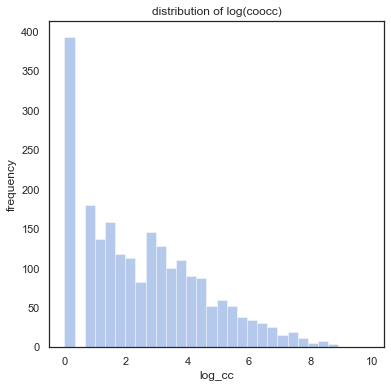

In [60]:
filtered=cc_vals_df[cc_vals_df["cooccurrence"]>0]
plt.figure(figsize=(6,6))
plt.title("distribution of log(coocc)")
plt.xlabel("coocc")
plt.ylabel("frequency")
_=sb.distplot(filtered["log_cc"],kde=False,bins=30)

### Number of non-empty interesections/columns (friend labels) vs rank

Let the number of labels that a label **L** intersects with be called "friends".

array([ 22,  17,  21,  17,  16,  28,  21,  17,  12,  15,  24,  28,  19,
         7,  23,  11,  23,  18,  17,  21,  22,  22,  26,  21,  25,  25,
        29,  31,  14,  32,  14,  24,  29,  21,  30,   7,  22,  28,  39,
        25,  13,  39,  44,  29,  20,  24,  51,  25,  26,  49,  47,  40,
        21,  58,  51,  54,  52,  49,  51,  52,  47,  43,  61,  54,  39,
        52,  22,  40,  48,  57,  47,  54,  55,  58,  64,  55,  56,  56,
        60,  78,  61,  74,  68,  60,  74,  76,  79,  85,  79,  71,  81,
        88,  95,  79,  94,  72,  90,  97,  99, 100, 100])

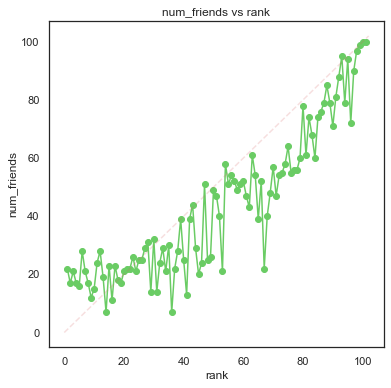

In [61]:
cc_mat=cc_mat_copy
friend_counts=np.sum((cc_mat>0)*1,axis=0)-1
display(friend_counts)
plt.figure(figsize=(6,6))
plt.title("num_friends vs rank")
plt.xlabel("rank")
plt.ylabel("num_friends")
plt.plot(np.arange(1,num_labels+1),friend_counts,"o-g")
_=plt.plot(np.arange(0,num_labels+2),np.arange(0,num_labels+2),"--r",alpha=0.2)

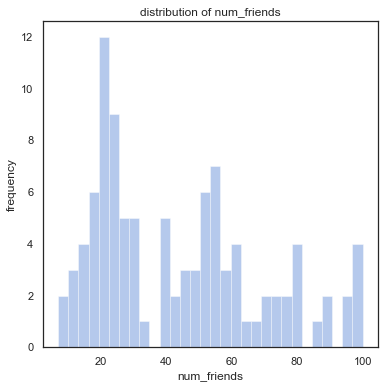

In [62]:
plt.figure(figsize=(6,6))
plt.title("distribution of num_friends")
plt.xlabel("num_friends")
plt.ylabel("frequency")
_=sb.distplot(friend_counts,kde=False,bins=30)

### Average labelset length vs rank

In [63]:
lset_lengths_means=np.zeros(num_labels)
lset_lengths_variances=np.zeros(num_labels)
for i in range(0,num_labels):
    supp=y_mat[:,i]>0
    lengths=np.sum(y_mat[supp,:],axis=1)
    lset_lengths_means[i]=np.mean(lengths)
    lset_lengths_variances[i]=np.var(lengths)

In [64]:
print(lset_lengths_means)
print(lset_lengths_variances)

[7.22727273 7.56521739 6.95833333 7.125      4.95833333 7.04
 7.53846154 6.         3.92592593 6.18518519 8.55555556 8.90322581
 6.51515152 4.52941176 6.26315789 3.76315789 5.92857143 6.73809524
 8.60465116 5.76086957 6.83333333 8.6122449  6.82692308 5.74193548
 5.77272727 4.94117647 4.08823529 6.24637681 4.125      7.
 6.65384615 5.32051282 6.4        8.40740741 6.03703704 4.31868132
 5.77894737 5.80808081 6.92079208 8.05785124 5.96992481 6.87234043
 7.22377622 5.80662983 6.66486486 2.71808511 7.54       4.58095238
 6.53953488 6.89908257 6.77522936 6.9650655  5.95582329 7.2173913
 5.7007874  8.25968992 7.90181818 4.8590604  6.43853821 7.1986755
 6.84437086 7.07164179 6.9852071  7.79022989 5.47169811 6.64231738
 7.89698492 6.21921182 7.35334873 6.15800866 5.45738046 4.16966068
 5.34164223 5.78343023 7.17729592 5.66817156 4.27320675 7.2537594
 5.29244444 6.6572549  5.7758501  5.64895763 7.99206349 6.07367758
 6.99937695 7.36470078 6.92493847 6.49330709 7.60758543 5.5782957
 6.78883639 6

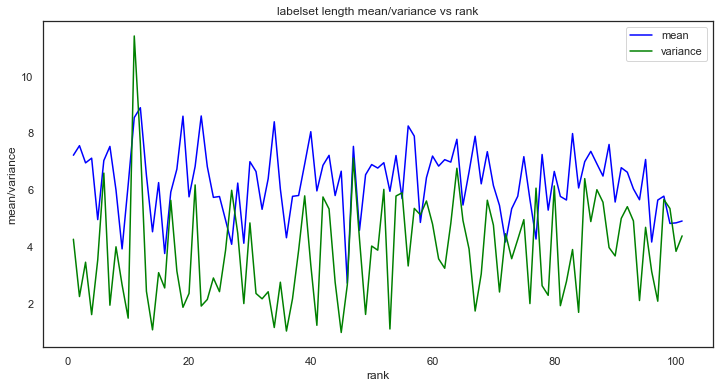

In [65]:
plt.figure(figsize=(12,6))
plt.title("labelset length mean/variance vs rank")
plt.xlabel("rank")
plt.ylabel("mean/variance")
plt.plot(np.arange(1,num_labels+1),lset_lengths_means,color="blue",label="mean")
plt.plot(np.arange(1,num_labels+1),lset_lengths_variances,color="green",label="variance")
_=plt.legend()

## Label separability

In [66]:
from sklearn.metrics import silhouette_score

In [67]:
sepa_df=pd.DataFrame(columns=["count","ratio","silhouette"],index=np.arange(0,num_labels))
lcounts=np.sum(y_mat,axis=0)
sepa_df.loc[:,"count"]=lcounts
sepa_df.loc[:,"ratio"]=lcounts/num_points
for i in range(0,num_labels):
    sepa_df.loc[i,"silhouette"]=silhouette_score(x_mat, y_mat[:,i])

In [68]:
sepa_df[sepa_df["silhouette"]<0]

,count,ratio,silhouette
4,24,0.000774,-0.140562
7,26,0.000839,-0.0110895
8,27,0.000871,-0.153246
9,27,0.000871,-0.0939066
11,31,0.001000,-0.0748448
13,34,0.001097,-0.116239
16,42,0.001355,-0.123096
18,43,0.001387,-0.0575902
19,46,0.001484,-0.0927409
20,48,0.001549,-0.117602
